# Test Cohort Characteristics

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 28JAN2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. Test Cohort Characteristics

<a id="0"></a>

## Notebook Content

1.  [Cohort Characteristics: Test Cohort](#1)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. Cohort Characteristics: Test Cohort
<a id="1"></a>

In [2]:
testcohort = pd.read_excel('data/testcohort.xlsx')

In [3]:
data2 = testcohort.filter(["Patient ID", "Gender", "BMI", "Smoker", 
                                 "Age", "Race", "Groups"])
data2.head()

,Patient ID,Gender,BMI,Smoker,Age,Race,Groups
1,PD003,Male,30.6,Never,64.9,White,RCC
3,PD012,Male,24.7,Never,84.8,White,RCC
4,PD014,Male,32.2,Former,55.7,White,RCC
5,PD015,Male,27.8,Never,59.0,White,RCC
6,PD022,Female,32.2,Never,44.7,White,RCC


In [4]:
data2.Groups.value_counts()

Control    143
RCC         51
Name: Groups, dtype: int64

#### Quantitative Meta Data

In [5]:
def cohortQuant(cohortID, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the numerical cohort characteristics between two groups
    
    Inputs: 
    cohortID = A list of the numerical cohort characteristics
    dfControl = A pandas dataframe containing the control group cohort data
    dfTreat =  A pandas dataframe containing the treatment group cohort data
    alpha = alpha for statistical significant judgment, Default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    pvaluelist = []
    commentlist = []
    for conf in cohortID:
        statistic, pvalue = scipy.stats.ttest_ind(dfControl[conf], dfTreat[conf], 
                                              equal_var=var)
        pvaluelist.append(pvalue)
        if pvalue > alpha:
            comment = 'not significant'
        else:
            comment = 'significant'
        commentlist.append(comment)
    ConfTable = pd.DataFrame({'Confounder': cohortID, 
                              'T-test p-value': pvaluelist, 
                              'Comment': commentlist})
    return ConfTable

In [6]:
confounderID = ['Age', 'BMI']
dControl = data2[(data2['Groups'] == 'Control')]
dRCC = data2[(data2['Groups'] == 'RCC')]
cohortQuant(confounderID, dControl, dRCC, var=False) # Welch t-test. 

,Confounder,T-test p-value,Comment
0,Age,0.000230,significant
1,BMI,0.031719,significant


In [7]:
print('CONTROL', dControl.filter(['Age', 'BMI'], axis=1).describe())
print('RCC', dRCC.filter(['Age', 'BMI'], axis=1).describe())

CONTROL               Age         BMI
count  143.000000  143.000000
mean    53.678322   27.504196
std      9.523582    4.439656
min     22.000000   19.200000
25%     47.500000   24.750000
50%     54.000000   26.900000
75%     59.000000   29.950000
max     83.000000   46.600000
RCC              Age        BMI
count  51.000000  51.000000
mean   61.752941  29.425490
std    13.689256   5.676472
min    30.200000  15.700000
25%    54.400000  25.000000
50%    61.600000  30.000000
75%    72.400000  31.900000
max    84.800000  45.000000


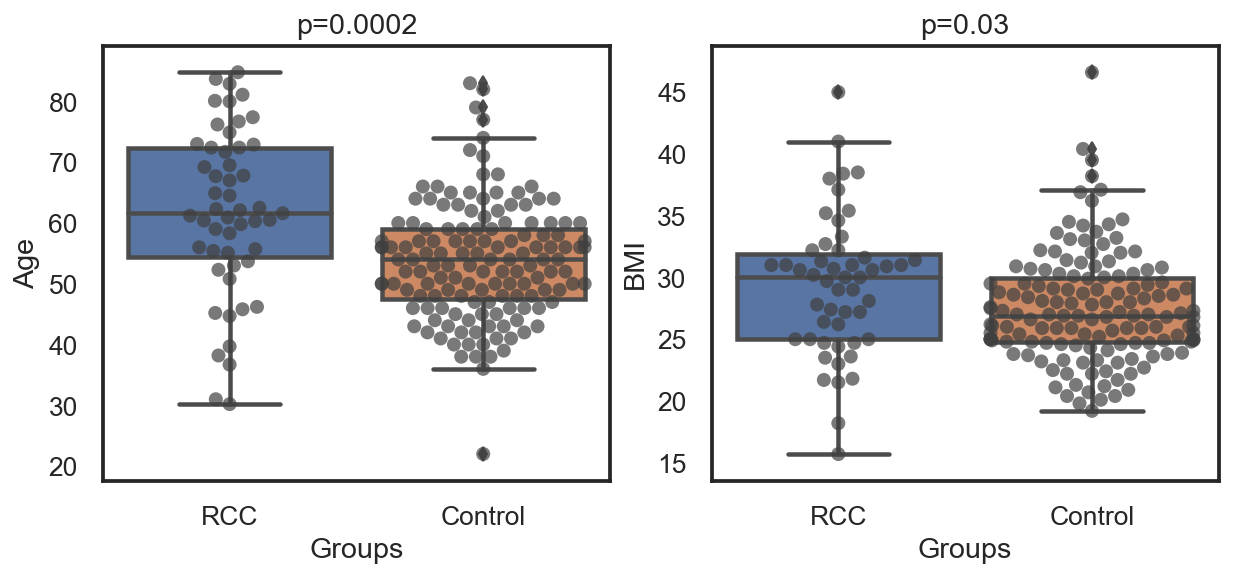

In [8]:
_, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

Age = sns.boxplot(x='Groups', y='Age', data=data2, ax=axes[0]);
sns.swarmplot(x='Groups', y='Age', data=data2, s =7, alpha=0.7, color=".25", ax=axes[0])
BMI = sns.boxplot(x='Groups', y='BMI', data=data2, ax=axes[1]);
sns.swarmplot(x='Groups', y='BMI', data=data2, s =7, alpha=0.7, color=".25", ax=axes[1])
Age.set_title('p=0.0002',loc='center');
BMI.set_title('p=0.03',loc='center');
#plt.savefig('testcohort_Age_BMI.svg') 

#### Categorical Meta Data

In [9]:
# Recall that Former and Current were treated as one entity in PS matching. 
data2['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, inplace=True);
data2['Race'].replace({'American-Indian/Alaskan-Native': 'Others', 'Asian': 'Others', 
                      'Mixed': 'Others', 'Unk/Missing': 'Others'}, inplace=True);

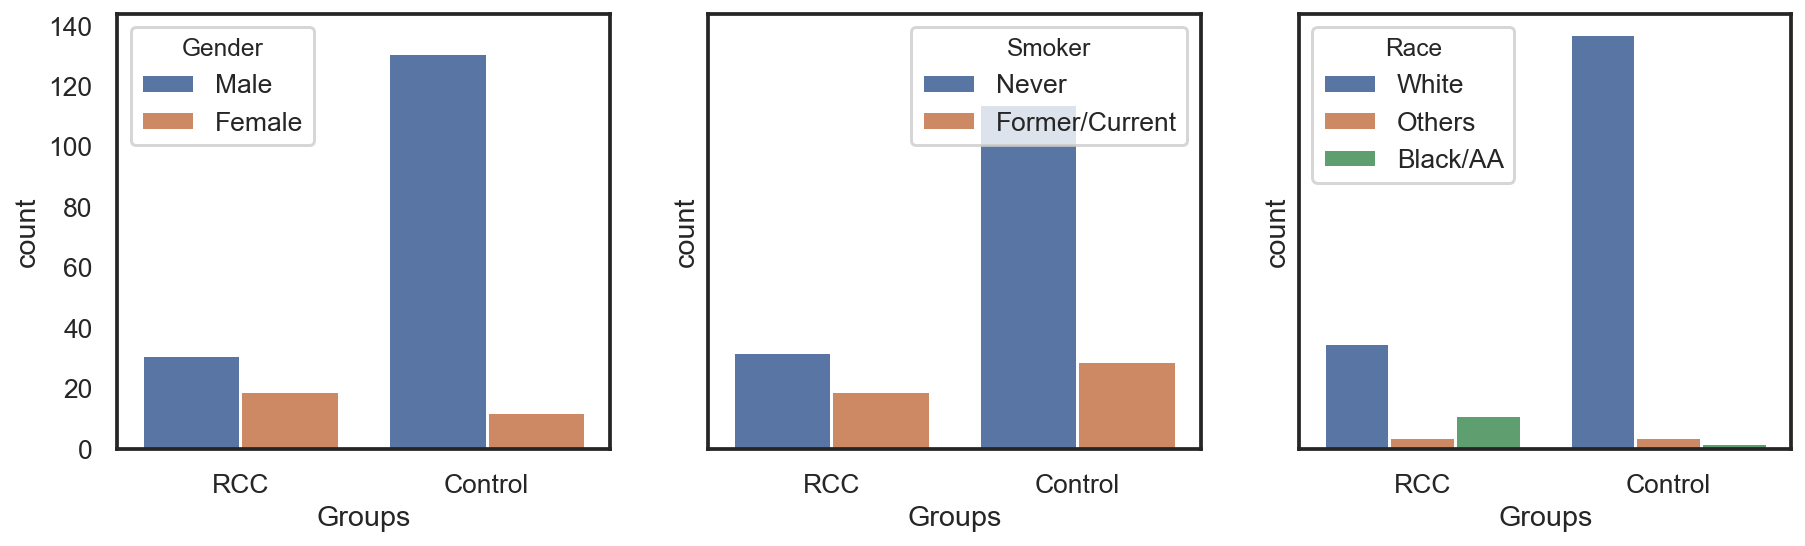

In [10]:
_, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 4))

sns.countplot(x='Groups', hue='Gender', data=data2, ax=axes[0]);
sns.countplot(x='Groups', hue='Smoker', data=data2, ax=axes[1]);
sns.countplot(x='Groups', hue='Race', data=data2, ax=axes[2]);

__Pie Chart__

In [11]:
def pieChart(dataframe, tilt_num, explode=False, shadow=False): 
    '''
    DEPENDENCY: matplotlib.pyplot.pie
    
    INPUTS: 
    dataframe = A pandas dataframe with category in the first column and associated data in the second column
    tilt_num = A number that specifies the amount of offset to apply to the wedge corresponding to the dataset 
    on the last row. The purpose of this is to make pie-chart annotation visible in the case of an overlapping 
    annotation. For best results, choose number between 0 and 1.  
    
    explode = Boolean. Set to True to make the tilt_num parameters applicable. 
    
    shadow = Boolean. Set to True for wedge shadows
    
    OUTPUTS: A pie chart figure. 
    
    '''
    if explode==False: 
        plt.pie(
        # using data
        dataframe.iloc[:, 1],
        # labels
        labels=dataframe.iloc[:, 0],
        # with no shadows
        shadow=shadow,
        # with the start angle at 90%
        startangle=90,
        # with the percent listed as a fraction
        autopct='%1.1f%%')
    
        # View the plot drop above
        plt.axis('equal')
        # View the plot
        plt.tight_layout()
        fig = plt.plot()
        return fig
    else:
        lst = [0] * dataframe.shape[0] # create a list of length equal to number of pie, sets to zero
        lst[-1] = tilt_num # replace the last digit of lst with the tilt_num
        plt.pie(dataframe.iloc[:, 1], labels=dataframe.iloc[:, 0],
        shadow=shadow, explode=lst, startangle=90, autopct='%1.1f%%')
    
        # View the plot drop above
        plt.axis('equal')
        # View the plot
        plt.tight_layout()
        fig = plt.plot()
    return fig

Gender

In [12]:
print(dControl['Gender'].value_counts())
print(dControl['Gender'].value_counts(normalize=True)*100)
print(dRCC['Gender'].value_counts())
print(dRCC['Gender'].value_counts(normalize=True)*100)

Male      131
Female     12
Name: Gender, dtype: int64
Male      91.608392
Female     8.391608
Name: Gender, dtype: float64
Male      31
Female    19
Name: Gender, dtype: int64
Male      62.0
Female    38.0
Name: Gender, dtype: float64


_Control_

[]

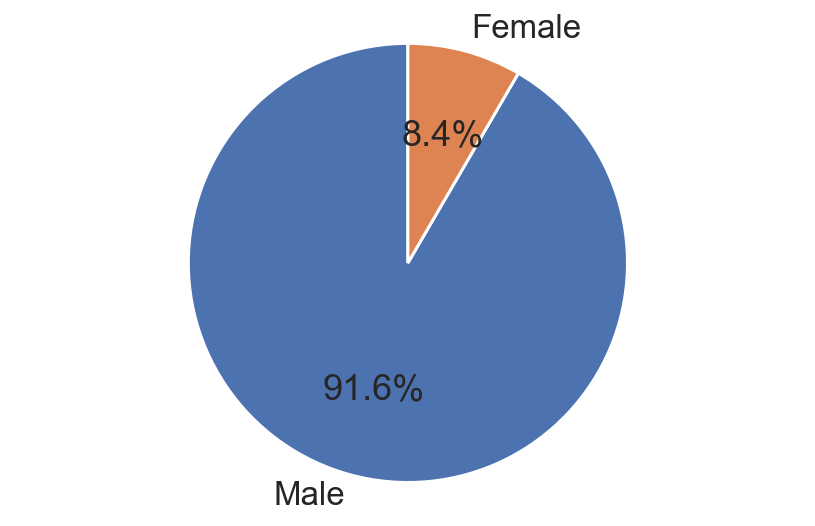

In [13]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=1.0)
raw_data = {'Gender': ['Male', 'Female'], 'Numbers': [131, 12]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('testcohort_N_Gender.svg') 

_RCC_

[]

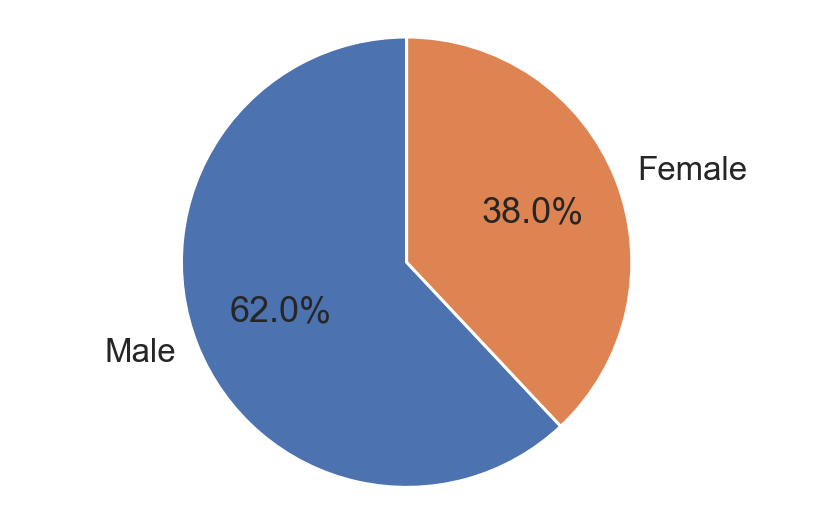

In [14]:
raw_data = {'Gender': ['Male', 'Female'], 'Numbers': [31, 19]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('testcohort_C_Gender.svg') 

__Smoking History__

In [15]:
data2.Smoker.value_counts()

Never             146
Former/Current     48
Name: Smoker, dtype: int64

In [16]:
dControl = data2[(data2['Groups'] == 'Control')]
dRCC = data2[(data2['Groups'] == 'RCC')]
print(dControl['Smoker'].value_counts())
print(dControl['Smoker'].value_counts(normalize=True)*100)
print(dRCC['Smoker'].value_counts())
print(dRCC['Smoker'].value_counts(normalize=True)*100)

Never             114
Former/Current     29
Name: Smoker, dtype: int64
Never             79.72028
Former/Current    20.27972
Name: Smoker, dtype: float64
Never             32
Former/Current    19
Name: Smoker, dtype: int64
Never             62.745098
Former/Current    37.254902
Name: Smoker, dtype: float64


_Control_

[]

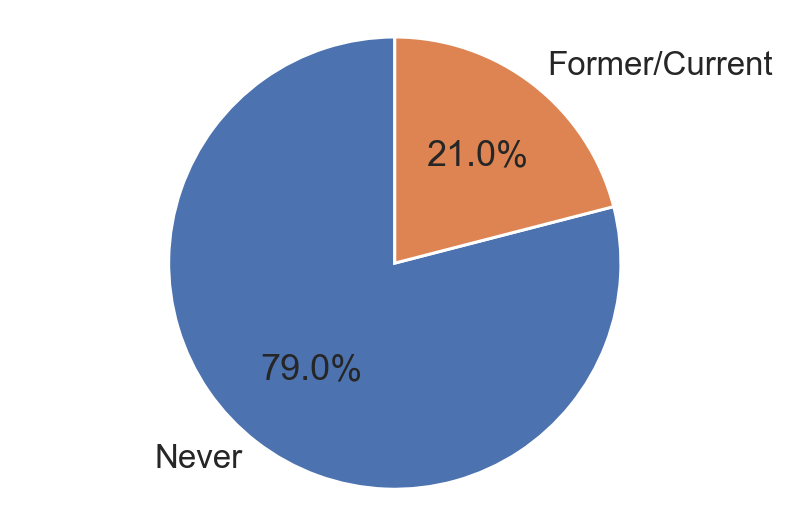

In [17]:
raw_data = {'Smoker': ['Never', 'Former/Current'],
            'Numbers': [113, 30]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('testcohort_N_Smoke.svg') 

_RCC_

[]

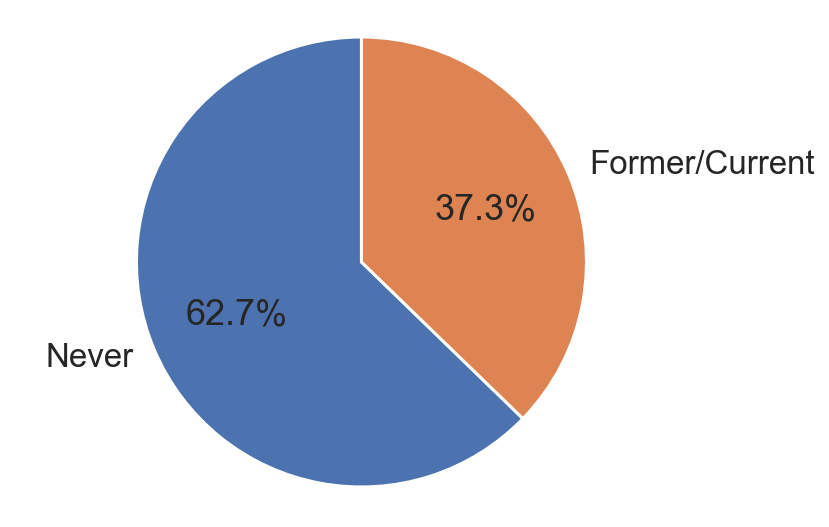

In [18]:
raw_data = {'Smoker': ['Never', 'Former/Current'],
            'Numbers': [32, 19]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('testcohort_C_Smoke.svg') 

__Race__

In [19]:
data2.Race.value_counts()

White       172
Black/AA     13
Others        8
Name: Race, dtype: int64

In [20]:
dControl = data2[(data2['Groups'] == 'Control')]
dRCC = data2[(data2['Groups'] == 'RCC')]
print(dControl['Race'].value_counts())
print(dControl['Race'].value_counts(normalize=True)*100)
print(dRCC['Race'].value_counts())
print(dRCC['Race'].value_counts(normalize=True)*100)

White       137
Others        4
Black/AA      2
Name: Race, dtype: int64
White       95.804196
Others       2.797203
Black/AA     1.398601
Name: Race, dtype: float64
White       35
Black/AA    11
Others       4
Name: Race, dtype: int64
White       70.0
Black/AA    22.0
Others       8.0
Name: Race, dtype: float64


_Control_

[]

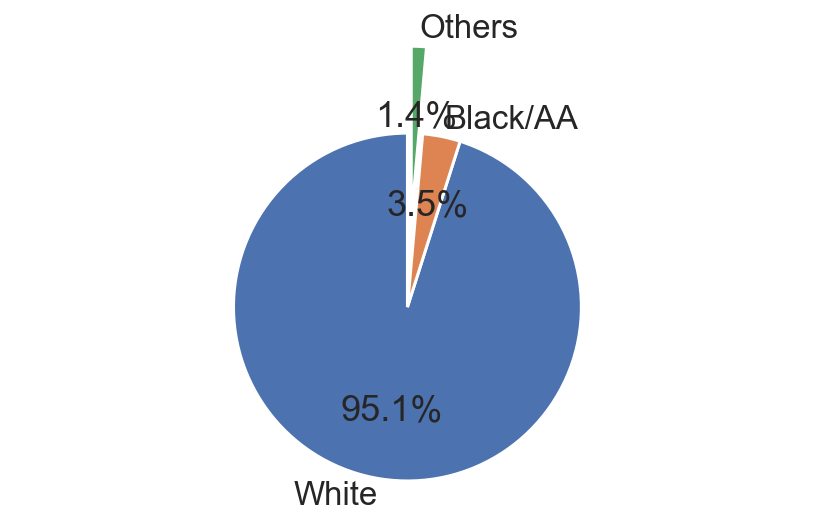

In [21]:
raw_data = {'Race': ['White', 'Black/AA', 'Others'],
            'Numbers': [136, 5, 2]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=True, shadow = False)
#plt.savefig('testcohort_N_Race.svg') 

_RCC_

[]

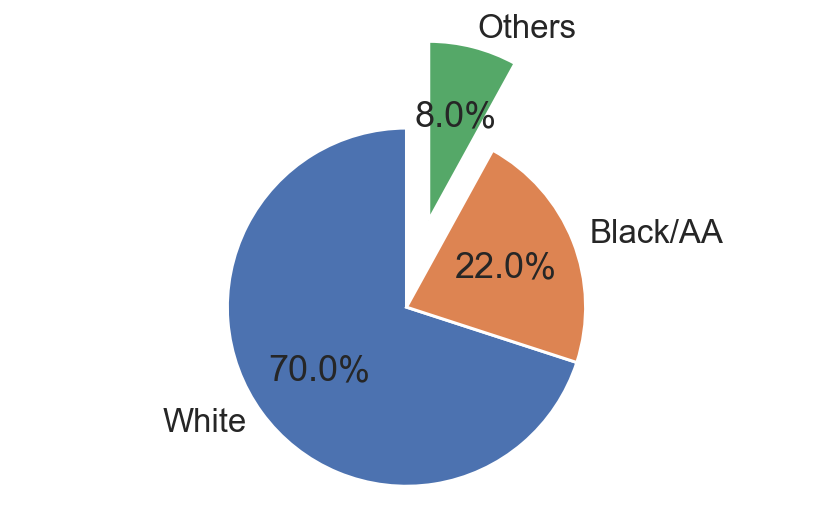

In [22]:
raw_data = {'Race': ['White', 'Black/AA', 'Others'],
            'Numbers': [35, 11, 4]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=True, shadow = False)
#plt.savefig('testcohort_C_Race.svg') 

### [Go back to notebook content](#0)